In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_1d_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users

--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussModel(mu0=0.0, sigma0=2.0, sigma=0.5)
📝 Created temporary observed data for prior sampling mode


In [2]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax

key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)
simulator.learn_summary_stats(subkey_learn, n_samples_max = 10000000)

key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: summary_learner_DeepSet_default_default (task: summary_learner)
INFO:abcnre.training.train:Starting summary_learner training
INFO:abcnre.training.train:Epochs: 100, Batch size: 256, Batches/epoch: 40


--- Step 1.5 : Learn Summary Stats (Optional) ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.registry:Created DeepSet network for summary_learner
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'phi_hidden_dims': [32, 16], 'rho_hidden_dims': [32, 16], 'output_dim': 1}
INFO:abcnre.training.train:Epoch 1/100 | Train Loss: 3.457086 | Val Loss: 2.647170 | LR: 0.000300 | Simulations: 10240 | Samples: 11274 | Time: 1.5s
INFO:abcnre.training.train:Epoch 11/100 | Train Loss: 0.436447 | Val Loss: 0.452909 | LR: 0.000291 | Simulations: 112640 | Samples: 113674 | Time: 3.1s
INFO:abcnre.training.train:Epoch 21/100 | Train Loss: 0.169600 | Val Loss: 0.187830 | LR: 0.000269 | Simulations: 215040 | Samples: 216074 | Time: 4.7s
INFO:abcnre.training.train:Epoch 31/100 | Train Loss: 0.106024 | Val Loss: 0.099904 | LR: 0.000234 | Simulation

✅ Updating model's summary statistics function...
📝 Created temporary observed data for prior sampling mode
✅ Summary statistics learned and updated successfully!
   - Original data dimension: (10,)
   - Learned summary function integrated into model
Shapes : phi_samples: (10000, 1) x_samples: (10000, 10, 1)
Shapes: summary_stats: (10000, 1) phi_samples: (10000, 1)
Correlation between summary statistics and model parameters: [[0.9943797]]


Array([[0.9943797]], dtype=float32)

In [3]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

true_theta = 2.5
key, subkey_sample = jax.random.split(key)
x_obs = simulator.model.simulate(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
🔄 Updated sampler with new observed data.
Observation x_obs: [[3.4455485]
 [2.2144976]
 [2.9423776]
 [2.731087 ]
 [3.105658 ]
 [2.3035314]
 [2.708934 ]
 [2.03835  ]
 [2.745885 ]
 [2.598302 ]]


In [4]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/a

--- Step 2.2: Save model to YAML (Optional) ---


INFO:abcnre.simulation.io:Loaded model: GaussGaussModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.registry:Created Dee

--- Step 2.3 : Load model from YAML and check (Optional) ---
Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


Text(0.5, 0, 'Phi samples')

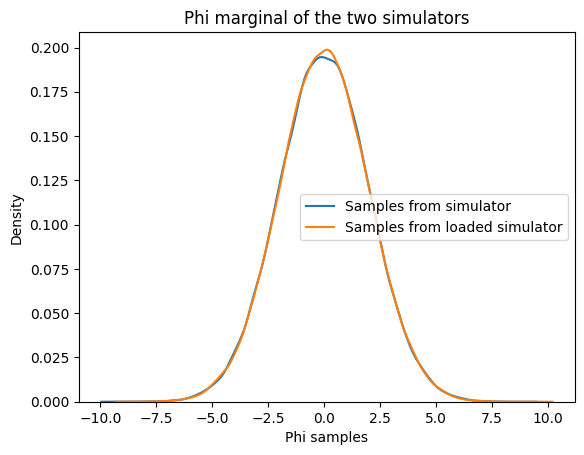

In [5]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [6]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="conditioned_deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

nn_config.training.num_epochs = 10
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-3

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_conditioned_deepset_default_default (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [7]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [8]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

INFO:abcnre.inference.estimator:Using ConditionedDeepSet without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.train:Starting classifier training
INFO:abcnre.training.train:Epochs: 10, Batch size: 1024, Batches/epoch: 10


--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for ConditionedDeepSet network
INFO:abcnre.training.registry:Created ConditionedDeepSet network for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'conditioning_mode': 'concat', 'phi_hidden_dims': [32, 16], 'rho_hidden_dims': [32, 16], 'output_dim': 1}
INFO:abcnre.training.train:Epoch 1/10 | Train Loss: 0.708454 | Val Loss: 0.696773 | Train Acc: 52% | Val Acc: 51% | LR: 0.001000 | Simulations: 5120 | Samples: 11274 | Time: 1.0s
INFO:abcnre.training.train:Training completed in 1.6s
INFO:abcnre.training.train:Final train loss: 0.589604
INFO:abcnre.training.train:Final val loss: 0.581776
INFO:abcnre.training.train:Final val accuracy: 72%
INFO:abcnre.training.train:Total simulations: 51200


Returning stored phi values
✅ Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.5896043181419373
   - Total simulations: 51200


In [9]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnr

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---
True stored_phis attribute not found in estimator


INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GaussGaussModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_s

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


Text(0.5, 1.0, 'Phi marginal of the two estimators')

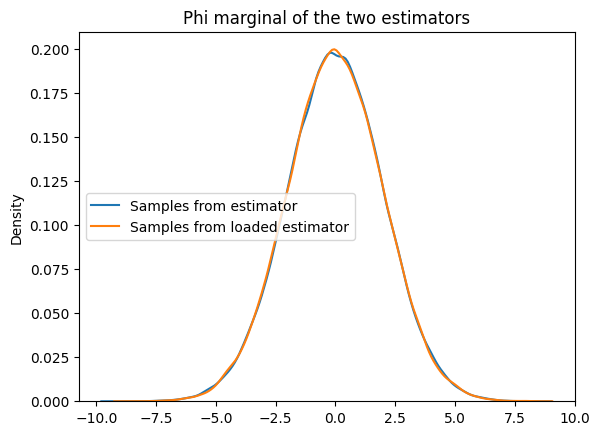

In [ ]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 